In [227]:
import tensorflow as tf
import DataSets as ds
import numpy as np
import Layers
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import StandardScaler
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

LoadModel = False

In [15]:
experiment_size = 100
train = ds.DataSet('Databases/data_%dk.bin'%experiment_size,'Databases/gender_%dk.bin'%experiment_size,1000*experiment_size)
test = ds.DataSet('Databases/data_test10k.bin','Databases/gender_test10k.bin',10000)

nb data =  100000
nb data =  10000


In [285]:
class ConvNeuralNet(tf.Module):
    def __init__(self):
        self.unflat = Layers.unflat('unflat',48, 48, 1)
        self.cv1 = Layers.conv('conv_1', output_dim=3, filterSize=3, stride=1)
        self.mp = Layers.maxpool('pool', 2)
        self.cv2 = Layers.conv('conv_2', output_dim=6, filterSize=3, stride=1)
        self.cv3 = Layers.conv('conv_3', output_dim=12, filterSize=3, stride=1)
        self.flat = Layers.flat()
        self.fc = Layers.fc('fc', 2)
        
    def __call__(self, x, log_summary):
        x = self.unflat(x, log_summary)
        x = self.cv1(x, log_summary)
        x = self.mp(x)
        x = self.cv2(x, log_summary)
        x = self.mp(x)
        x = self.cv3(x, log_summary)
        x = self.mp(x)
        x = self.flat(x)
        x = self.fc(x, log_summary)
        return x  
    

In [286]:
def train_one_iter(model, optimizer, image, label, log_summary):
    with tf.GradientTape() as tape:
        y = model(image,log_summary)
        y = tf.nn.log_softmax(y)
        diff = label * y
        loss = -tf.reduce_sum(diff)
        if log_summary:
            tf.summary.scalar('cross entropy', loss)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss 

In [6]:
print ("-----------------------------------------------------")
print ("----------------------- %dk -------------------------"%experiment_size)
print ("-----------------------------------------------------")

train_summary_writer = tf.summary.create_file_writer('logs %dk'%experiment_size)
optimizer = tf.optimizers.Adam(1e-3)
simple_cnn = ConvNeuralNet()

if LoadModel:
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=simple_cnn)
    ckpt.restore('./saved_model-1')


for iter in range(5000):
    tf.summary.experimental.set_step(iter)

    if iter % 500 == 0:
        with train_summary_writer.as_default():
            acc1 = train.mean_accuracy(simple_cnn) * 100
            acc2 = test.mean_accuracy(simple_cnn) * 100
            print("iter= %6d accuracy - train= %.2f%% - test= %.2f%%" % (iter, acc1, acc2))

    ima, lab = train.NextTrainingBatch()
    with train_summary_writer.as_default():
        loss = train_one_iter(simple_cnn, optimizer, ima, lab, iter % 10 == 0)

    if iter % 100 == 0:
        print("iter= %6d - loss= %f" % (iter, loss))

if not LoadModel:
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=simple_cnn)
    ckpt.save('./saved_model_2-1')

-----------------------------------------------------
----------------------- 100k -------------------------
-----------------------------------------------------
def unflat unflat ? => 48 48 1
build conv conv_1 3x3  1 => 3
build conv conv_2 3x3  3 => 6
build conv conv_3 3x3  6 => 12
build fc fc  432 => 2
iter=      0 accuracy - train= 56.58% - test= 56.75%
iter=      0 - loss= 88.649109
iter=    100 - loss= 72.740341
iter=    200 - loss= 71.138046
iter=    300 - loss= 68.339371
iter=    400 - loss= 67.184219
iter=    500 accuracy - train= 80.81% - test= 79.75%
iter=    500 - loss= 65.663017
iter=    600 - loss= 58.754494
iter=    700 - loss= 57.657631
iter=    800 - loss= 51.482700
iter=    900 - loss= 47.855793
iter=   1000 accuracy - train= 82.43% - test= 81.44%
iter=   1000 - loss= 63.258301
iter=   1100 - loss= 53.306465
iter=   1200 - loss= 57.352890
iter=   1300 - loss= 53.431862
iter=   1400 - loss= 72.994125
iter=   1500 accuracy - train= 84.01% - test= 83.21%
iter=   1500 - l

### 2/ find on the web, the face image of a person

#### Test sur image

In [287]:
image_raw = tf.io.read_file('femme.jpg')
image = tf.image.decode_image(image_raw,channels=1)
image = np.array(image).reshape(48,48)

In [288]:
cv2.imwrite("adv_lalifinaritra_fangue_ori.png",image)

True

#### Plot image originale

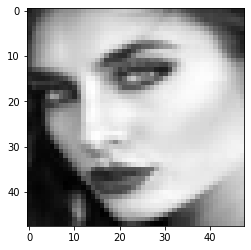

In [289]:
plt.imshow(image, cmap='gray')

### 3/ write a small stand alone script

#### Load Model

In [290]:
LoadModel = True
optimizer = tf.optimizers.Adam(1e-3)
simple_cnn = ConvNeuralNet()
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=simple_cnn)
ckpt.restore('./saved_model_2-1-1')

def unflat unflat ? => 48 48 1


In [291]:
print(test.mean_accuracy(simple_cnn))

build conv conv_1 3x3  1 => 3
build conv conv_2 3x3  3 => 6
build conv conv_3 3x3  6 => 12
build fc fc  432 => 2
tf.Tensor(0.8591, shape=(), dtype=float32)


#### Predict gender

In [292]:
scaler = StandardScaler()

In [293]:
image = scaler.fit_transform(image)

In [294]:
image = image.reshape(2304).astype('float32')

In [295]:
image.shape

(2304,)

In [296]:
pred = tf.nn.softmax(simple_cnn(image,False))
print(pred)

tf.Tensor([[2.1283313e-06 9.9999785e-01]], shape=(1, 2), dtype=float32)


### 4/ Modify your image in order to mislead your CNN detector.

#### Add Adversarial

In [297]:
def adversarial(model, optimizer, image, dx, label):
    with tf.GradientTape() as tape:
        y = model(image + dx,False)
        y = tf.nn.log_softmax(y)
        diff = label * y
        loss = -tf.reduce_sum(diff)
        grads = tape.gradient(loss, [dx])
        optimizer.apply_gradients(zip(grads, [dx]))
    return dx

#### utilisation de la méthode adversarial

In [298]:
dx = tf.Variable(tf.zeros([2304]))
image = tf.convert_to_tensor(image)
label = [1.,0.]

In [299]:
DX = adversarial(simple_cnn,optimizer,image,dx,label)

In [302]:
eps = 1
image_dx = image + eps*DX
image_dx = tf.clip_by_value(image_dx, 0, 1)

In [303]:
pred = tf.nn.softmax(simple_cnn(image_dx,False))
print(pred)

tf.Tensor([[0.06102104 0.93897897]], shape=(1, 2), dtype=float32)


#### Plot image modifiée 

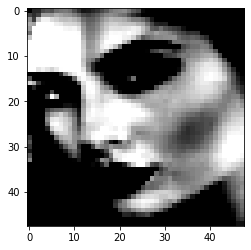

In [304]:
plt.imshow(np.array(tf.convert_to_tensor(image_dx)).reshape(48,48), cmap='gray')

#### Plot bruit DX

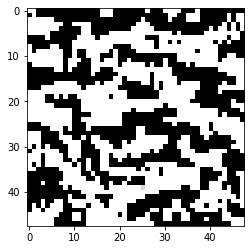

In [305]:
plt.imshow(np.array(tf.convert_to_tensor(DX)).reshape(48,48), cmap='gray')

#### Save image modifiée

In [306]:
image_mod = scaler.inverse_transform(np.array(tf.convert_to_tensor(image_dx)).reshape(48,48))

In [307]:
cv2.imwrite("adv_lalifinaritra_fangue_mod.png",image_mod)

True

#### 5/ Test the Modified Image with your small script.

#### Plot image amplifiée et prédiction

In [308]:
eps = 50
image_dx_50 = image + eps*DX
image_dx_50 = tf.clip_by_value(image_dx_50, 0, 1)

In [309]:
pred = tf.nn.softmax(simple_cnn(image_dx_50,False))
print(pred)

tf.Tensor([[0.917897   0.08210304]], shape=(1, 2), dtype=float32)


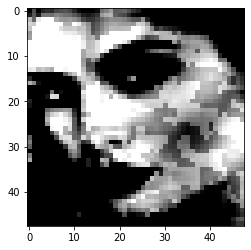

In [310]:
plt.imshow(np.array(tf.convert_to_tensor(image_dx_50)).reshape(48,48), cmap='gray')

#### Save image amplifiée

In [311]:
image_amp = scaler.inverse_transform(np.array(tf.convert_to_tensor(image_dx_50)).reshape(48,48))

In [312]:
cv2.imwrite("adv_lalifinaritra_fangue_amp.png",image_amp)

True

### 6/ Add a L2 constraint to DX to make it small

#### Add L2 regularization

In [313]:
def adversarial_l2(model, optimizer, image, dx, label):
    regularizer = tf.nn.l2_loss(dx)
    lr = 0.5
    with tf.GradientTape() as tape:
        y = model(image + dx,False)
        y = tf.nn.log_softmax(y)
        diff = label * y
        loss = -tf.reduce_sum(diff + lr * regularizer)
        grads = tape.gradient(loss, [dx])
        optimizer.apply_gradients(zip(grads, [dx]))    
    return dx

In [314]:
DX_l2 = adversarial_l2(simple_cnn,optimizer,image,dx,label)

In [315]:
image_dx_l2 = image + eps*DX_l2
image_dx_l2 = tf.clip_by_value(image_dx_l2, 0, 1)

In [316]:
pred = tf.nn.softmax(simple_cnn(image_dx_l2,False))
print(pred)

tf.Tensor([[9.995443e-01 4.556411e-04]], shape=(1, 2), dtype=float32)


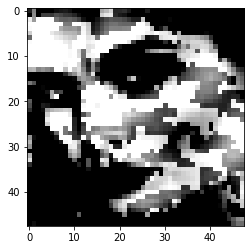

In [317]:
plt.imshow(np.array(tf.convert_to_tensor(image_dx_l2)).reshape(48,48), cmap='gray')

In [318]:
image_l2 = scaler.inverse_transform(np.array(tf.convert_to_tensor(image_dx_l2)).reshape(48,48))

In [319]:
cv2.imwrite("adv_lalifinaritra_fangue_l2.png",image_l2)

True